In [1]:
import pandas as pd
import pypsa
import urllib3
import plotly.graph_objects as go
import calendar
urllib3.disable_warnings()

In [2]:
# Load Technology data
year = 2025
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]


In [3]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n


In [4]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

In [5]:
network = pypsa.Network()

In [6]:
def optimizer(year):
    hours_in_year = pd.date_range(f'{year}-01-01 00:00Z',
                                f'{year}-12-31 23:00Z',
                                freq='h')

    network.set_snapshots(hours_in_year.values)

    network.add("Bus",
                "electricity bus", overwrite=True)

    # load electricity demand data
    df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
    df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
    country='IRL'
    print(df_elec[country].head())

    # add load to the bus
    network.add("Load",
        "load",
        bus="electricity bus",
        p_set=df_elec[country].values,
        overwrite=True)
    

    # add the different carriers, only gas emits CO2
    network.add("Carrier", "gas", co2_emissions= costs.at["gas", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network.add("Carrier", "onshorewind", overwrite=True)
    network.add("Carrier", "solar", overwrite=True)
    network.add("Carrier", "coal", co2_emissions = costs.at["coal", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network.add("Carrier", "biomass", co2_emissions = costs.at["biomass", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network.add("Carrier", "oil", co2_emissions = costs.at["oil", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network.add("Carrier", "offshorewind", overwrite=True)

    # add onshore wind generator
    df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
    df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
    CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    network.add("Generator",
                "onshorewind",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="onshorewind",
                p_nom_max=4810-25.2, # maximum capacity can be limited due to environmental constraints. Based on electricity maps - minus the off shore wind capacity
                capital_cost = costs.at["onwind", "capital_cost"], # in €/MW
                marginal_cost = 0,
                p_max_pu = CF_wind.values,
                overwrite=True)

    # add solar PV generator
    df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
    df_solar.index = pd.to_datetime(df_solar.index)
    CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    network.add("Generator",
                "solar",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="solar",
                p_nom_max = 740, # maximum capacity can be limited due to environmental constraints Based on electricity maps
                capital_cost = costs.at["solar", "capital_cost"], # in €/MW
                marginal_cost = 0,
                p_max_pu = CF_solar.values,
                overwrite=True)

    # add OCGT (Open Cycle Gas Turbine) generator
    network.add("Generator",
                "OCGT",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="gas",
                p_nom_max=4270, #based on electricity maps
                capital_cost = costs.at["OCGT", "capital_cost"], #in €/MW
                marginal_cost = costs.at["OCGT", "marginal_cost"],
                overwrite=True)

    # add Coal generator
    network.add("Generator",
                "Coal",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="coal",
                p_nom_max=920, #based on electricity maps
                capital_cost = costs.at["coal", "capital_cost"], #in €/MW
                marginal_cost = costs.at["coal", "marginal_cost"],
                overwrite=True)

    # add biomass generator
    network.add("Generator",
                "Biomass",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="biomass",
                p_nom_max=70, #based on electricity maps 
                capital_cost = costs.at["biomass", "capital_cost"], #in €/MW
                marginal_cost = costs.at["biomass", "marginal_cost"],
                overwrite=True)

    # add oil generator
    network.add("Generator",
                "Oil",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="oil",
                p_nom_max=830, #based on electricity maps
                capital_cost = costs.at["oil", "capital_cost"], #in €/MW
                marginal_cost = costs.at["oil", "marginal_cost"],
                overwrite=True)

    # add offshore wind generator
    df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
    df_offshorewind.index = pd.to_datetime(df_offshorewind.index)
    CF_offshorewind = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    network.add("Generator",
                "offshorewind",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="offshorewind",
                p_nom_max=25.2, # maximum capacity can be limited due to environmental constraints. #Ireland doesnt have offshore wind today, but are proposing to install 5GW soon
                capital_cost = costs.at["offwind", "capital_cost"], # in €/MW
                marginal_cost = 0,
                p_max_pu = CF_offshorewind.values,
                overwrite=True)
    

    #Optimization
    status = network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})


    objective = network.objective
    capacities = network.generators.p_nom_opt #in MW
    loadConsumption = network.loads_t.p
    generation = network.generators_t.p
    snapshots = network.snapshots
    
    
    

    return objective, capacities, loadConsumption, generation, snapshots, status




In [7]:
objective, capacities, loadConsumption, generation, snapshot, status = optimizer(2015)

utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 40.32it/s]
INFO:linopy.io: Writing time: 0.36s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-f85pd4iu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-f85pd4iu.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 131414 rows, 61327 columns, 240914 nonzeros


INFO:gurobipy:obj: 131414 rows, 61327 columns, 240914 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131414 duals
Objective: 2.60e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [8]:
status[1]

'optimal'

In [9]:
def plot_dispatch_winter():
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=snapshot[:96], y=loadConsumption['load'][:96], mode='lines', name='demand', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['onshorewind'][:96], mode='lines', name='onshore wind', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['solar'][:96], mode='lines', name='solar', line=dict(color='orange')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['OCGT'][:96], mode='lines', name='gas (OCGT)', line=dict(color='brown')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['Coal'][:96], mode='lines', name='coal', line=dict(color='grey')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['Biomass'][:96], mode='lines', name='biomass', line=dict(color='green')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['Oil'][:96], mode='lines', name='oil', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['offshorewind'][:96], mode='lines', name='offshore wind', line=dict(color='purple')))

    fig.update_layout(title='Electricity Dispatch Week 1 2015',
                    xaxis_title='Time',
                    yaxis_title='Power (MW)',
                    legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()

In [10]:
plot_dispatch_winter()

# B)

In [11]:
# Add the CO2 constraint to the copied network
co2_limit = 3000000  # tonCO2
network.add("GlobalConstraint",
                 "co2_limit",
                 type="primary_energy",
                 carrier_attribute="co2_emissions",
                 sense="<=",
                 constant=co2_limit,
                 overwrite=True)

Index(['co2_limit'], dtype='object')

In [12]:
objective, capacities, loadConsumption, generation, snapshot, staus = optimizer(2015)
plot_dispatch_winter()

utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 40.32it/s]
INFO:linopy.io: Writing time: 0.36s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-hyy71j4r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-hyy71j4r.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 9.50e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [13]:
objectives = {}
capacities_dic = {}
loadConsumptions = {}
generations = {}
snapshots = {}
for Co2_limit in range(2000000, 5000000, 500000):
    network.add("GlobalConstraint",
                 "co2_limit",
                 type="primary_energy",
                 carrier_attribute="co2_emissions",
                 sense="<=",
                 constant=Co2_limit,
                 overwrite=True)
    objective, capacities, loadConsumption, generation, snapshot, status = optimizer(2015)
    if status[1] == "optimal":
        objectives[Co2_limit] = objective
        capacities_dic[Co2_limit] = capacities
        loadConsumptions[Co2_limit] = loadConsumption
        generations[Co2_limit] = generation
        snapshots[Co2_limit] = snapshot
    

utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 39.95it/s]
INFO:linopy.io: Writing time: 0.37s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-vns9z62d.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-vns9z62d.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.solvers:Unable to save solution file. Raised error: Unable to retrieve attribute 'X'
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 39.72it/s]
INFO:linopy.io: Writing time: 0.37s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-j_4ba4t3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-j_4ba4t3.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.solvers:Unable to save solution file. Raised error: Unable to retrieve attribute 'X'
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 39.17it/s]
INFO:linopy.io: Writing time: 0.37s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-d6q1te9q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-d6q1te9q.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 9.50e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 40.20it/s]
INFO:linopy.io: Writing time: 0.37s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-llu9o2n1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-llu9o2n1.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 7.81e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 40.78it/s]
INFO:linopy.io: Writing time: 0.4s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-ehy1xqsu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-ehy1xqsu.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 6.25e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 40.07it/s]
INFO:linopy.io: Writing time: 0.36s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-1iy2zke8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-1iy2zke8.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 4.70e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [14]:
def plot_mix(generator, co2_limit):


    labels = ['onshore wind', 'solar', 'gas (OCGT)', 'coal', 'biomass', 'oil', 'offshore wind']
    sizes = [generator['onshorewind'].sum(),
                    generator['solar'].sum(),
                    generator['OCGT'].sum(),
                    generator['Coal'].sum(),
                    generator['Biomass'].sum(),
                    generator['Oil'].sum(),
                    generator['offshorewind'].sum()]

    colors = ['blue', 'orange', 'brown', 'grey', 'green', 'black', 'purple']

    fig = go.Figure(data=[go.Pie(labels=labels, values=sizes, marker=dict(colors=colors))])

    fig.update_layout(title='Electricity mix',
                      annotations=[dict(text=f"CO2 limit: {co2_limit} tonCO2",
                                       x=0.5, y=1.3, font_size=20, showarrow=False)])

    fig.show()


In [15]:
#plot mix for g in generators and co2_limit
for co2_limit in objectives.keys():
    plot_mix(generations[co2_limit], co2_limit)

Based on research, the CO2-emissions from electricity production was 7.56mT CO2-eq in 2023. This will now be the limit:


In [16]:
network.add("GlobalConstraint",
                 "co2_limit",
                 type="primary_energy",
                 carrier_attribute="co2_emissions",
                 sense="<=",
                 constant=7560000,
                 overwrite=True)
objective, capacities, loadConsumption, generation, snapshot, status = optimizer(2015)

plot_mix(generation, 7560000)

utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 39.48it/s]
INFO:linopy.io: Writing time: 0.37s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-0g50q18s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-0g50q18s.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 2.60e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


# C)

In this task we will use a CO2 allowance of 3mT

In [17]:
network.add("GlobalConstraint",
                 "co2_limit",
                 type="primary_energy",
                 carrier_attribute="co2_emissions",
                 sense="<=",
                 constant=3000000,
                 overwrite=True)

objectives = {}
capacities_dic = {}
loadConsumptions = {}
generations = {}
snapshots = {}


for year in range(2013, 2017):
    if not calendar.isleap(year):  # only hit non-leap years
        objective, capacities, loadConsumption, generation, snapshot, status = optimizer(year)
        if status[1] == "optimal":
            print(f"Year {year} is optimal")
            objectives[year] = objective
            capacities_dic[year] = capacities
            loadConsumptions[year] = loadConsumption
            generations[year] = generation
            snapshots[year] = snapshot



utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 39.68it/s]
INFO:linopy.io: Writing time: 0.37s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-i994y6gq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-i994y6gq.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 131415 rows, 61327 columns, 267206 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267206 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.01e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2013 is optimal
utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 40.11it/s]
INFO:linopy.io: Writing time: 0.36s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-fs9sn9vo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-fs9sn9vo.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267211 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267211 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.07e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2014 is optimal
utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 40.09it/s]
INFO:linopy.io: Writing time: 0.37s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-9472n0wr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-9472n0wr.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 9.50e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2015 is optimal


## Objective with optimal CO2 limit for 2015

In [18]:
objective_optimalCO2, capacities, loadConsumption, generation, snapshot, status = optimizer("2015")


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 39.90it/s]
INFO:linopy.io: Writing time: 0.36s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-whnzhgau.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-whnzhgau.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 9.50e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [19]:
#make a 100% stacket area chart of the capacities for all years
def plot_capacities(years):
    fig = go.Figure()

    for generator in ['onshorewind', 'solar', 'OCGT', 'Coal', 'Biomass', 'Oil', 'offshorewind']:
        fig.add_trace(go.Scatter(x=years, y=[capacities_dic[year][generator] for year in years],
                                 mode='lines+markers',
                                 name=generator))

    fig.update_layout(title='Capacities over the years',
                      xaxis_title='Year',
                      yaxis_title='Capacity (MW)',
                      legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()
plot_capacities([year for year in range(2013, 2017) if not calendar.isleap(year)])

In [20]:
#make a 100% stacket area chart of the generation for all years
def plot_generation(years):
    fig = go.Figure()

    for generator in ['onshorewind', 'solar', 'OCGT', 'Coal', 'Biomass', 'Oil', 'offshorewind']:
        fig.add_trace(go.Scatter(x=years, y=[sum(generations[year][generator]) for year in years],
                                 mode='lines+markers',
                                 name=generator))

    fig.update_layout(title='Generation over the years',
                      xaxis_title='Year',
                      yaxis_title='Capacity (MW)',
                      legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()
plot_generation([year for year in range(2013, 2017) if not calendar.isleap(year)])

# D)

In [21]:
#values for pumped hydro
#costs.loc["Pumped-Storage-Hydro-store", :].T

In [22]:
print(costs.at["Pumped-Storage-Hydro-store", "capital_cost"])
print(costs.at["coal", "capital_cost"])
print(costs.at["offwind", "capital_cost"])
print(costs.at["OCGT", "capital_cost"])
print(costs.at["onwind", "capital_cost"])
print(costs.at["solar", "capital_cost"])
print(costs.at["oil", "capital_cost"])

13694770.916593747
668813344.7589797
248431757.57097575
57685985.73118066
154026277.9441863
112520110.2010592
44506255.460814066


In [23]:
#Create a new carrier
network.add("Carrier",
              "Hydro")

#Create a new bus
network.add("Bus",
          "Hydro Bus",
          carrier = "Hydro")

#Connect the Pumped Hydr Storage (PHS) to the Hydro Bus
network.add("Store",
          "PHS",
          bus = "Hydro Bus",
          e_nom_extendable = True,
          e_cyclic = True,
          e_nom_max = 240, #in MWh
          capital_cost = costs.at["Pumped-Storage-Hydro-store", "capital_cost"], 
          overwrite=True
)

#Add the link "Hydro pump" that transport energy from the electricity bus (bus0) to the Hydro bus (bus1)
#with 80% efficiency
network.add("Link",
          "Hydro pump",
          bus0 = "electricity bus",
          bus1 = "Hydro Bus",
          p_nom_extendable = True,
          efficiency = 0.85,
          capital_cost = 0, 
            overwrite=True
          )

#Add the link "Hydro turbine" that transports energy from the Hydro bus (bus0) to the electricity bus (bus1)
#with 58% efficiency
network.add("Link",
          "Hydro turbine",
          bus0 = "Hydro Bus",
          bus1 = "electricity bus",
          p_nom_extendable = True,
          efficiency = 0.9,
          capital_cost = 0,
            overwrite=True
        
          )



Index(['Hydro turbine'], dtype='object')

utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['Hydro pump'], dtype='object', name='Link')
Index(['electricity bus'], dtype='object', name='Bus')
Index(['Hydro pump'], dtype='object', name='Link')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 85.04it/s]
INFO:linopy.io: Writing time: 0.56s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-dthc_w12.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-dthc_w12.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 201499 rows, 96370 columns, 416118 nonzeros


INFO:gurobipy:obj: 201499 rows, 96370 columns, 416118 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 201499 duals
Objective: 9.41e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


<Axes: xlabel='snapshot', ylabel='Hydro storage'>

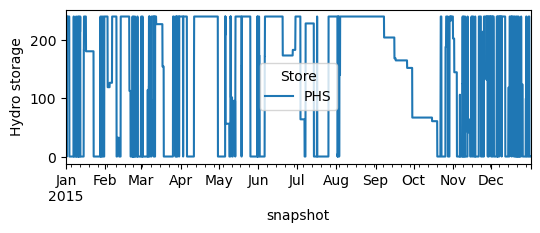

In [24]:

objective_hydro, capacities, loadConsumption, generation, snapshot, status = optimizer("2015")
network.stores_t.e.plot(figsize=(6, 2), ylabel="Hydro storage")



In [25]:
print("objective_optimalCO2: ", objective_optimalCO2)
print("objective_hydro: ", objective_hydro)

print("Savings using a pumped hydro storage: ", objective_optimalCO2 - objective_hydro)


objective_optimalCO2:  949655388041.6951
objective_hydro:  941122503492.8068
Savings using a pumped hydro storage:  8532884548.888306


In [26]:
# Re-run the optimizer to ensure 'Hydro Bus' is included in the network
objective_hydro, capacities, loadConsumption, generation, snapshot, status = optimizer(2015)



utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['Hydro pump'], dtype='object', name='Link')
Index(['electricity bus'], dtype='object', name='Bus')
Index(['Hydro pump'], dtype='object', name='Link')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 84.12it/s]
INFO:linopy.io: Writing time: 0.56s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-t2bs8n4t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-t2bs8n4t.lp


Reading time = 0.18 seconds


INFO:gurobipy:Reading time = 0.18 seconds


obj: 201499 rows, 96370 columns, 416118 nonzeros


INFO:gurobipy:obj: 201499 rows, 96370 columns, 416118 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 201499 duals
Objective: 9.41e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


In [27]:
#print the marginal price from electricity bus
print(network.buses_t.marginal_price['electricity bus'])
#plot the marginal price from electricity bus

def plot_marginal_price():
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=snapshot, y=network.buses_t.marginal_price['electricity bus'],
                             mode='lines', name='marginal price', line=dict(color='black')))

    fig.update_layout(title='Marginal Price',
                      xaxis_title='Time',
                      yaxis_title='Price (€/MWh)',
                      legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()
plot_marginal_price()

snapshot
2015-01-01 00:00:00    71662.261964
2015-01-01 01:00:00    71662.261964
2015-01-01 02:00:00    71662.261964
2015-01-01 03:00:00        0.000000
2015-01-01 04:00:00        0.000000
                           ...     
2015-12-31 19:00:00    71662.261964
2015-12-31 20:00:00    71662.261964
2015-12-31 21:00:00    71662.261964
2015-12-31 22:00:00    71662.261964
2015-12-31 23:00:00    71662.261964
Name: electricity bus, Length: 8760, dtype: float64


In [28]:

# make a df with the difference between hours
network.stores_t.e['PHS'].diff()

storage_generation = network.stores_t.e['PHS'].diff().apply(lambda x: x if x > 0 else 0)
storage_load = network.stores_t.e['PHS'].diff().apply(lambda x: x if x < 0 else 0)

storage_load = storage_load * -1

# print(network.stores_t.e['PHS'])
# print(network.stores_t.e['PHS'].diff().head)
# print(storage_generation.head(10))
# print(storage_load.head(10))


In [29]:
def plot_dispatch_winter_including_hydro():
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=snapshot[:96], y=loadConsumption['load'][:96], mode='lines', name='demand', line=dict(color='black', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['onshorewind'][:96], mode='lines', name='onshore wind', line=dict(color='blue', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['solar'][:96], mode='lines', name='solar', line=dict(color='orange', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['OCGT'][:96], mode='lines', name='gas (OCGT)', line=dict(color='brown', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['Coal'][:96], mode='lines', name='coal', line=dict(color='grey', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['Biomass'][:96], mode='lines', name='biomass', line=dict(color='green', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['Oil'][:96], mode='lines', name='oil', line=dict(color='black', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['offshorewind'][:96], mode='lines', name='offshore wind', line=dict(color='purple', shape='hv')))
    # add storage_load
    fig.add_trace(go.Scatter(x=snapshot[:96], y=storage_load[:96], mode='lines', name='storage load', line=dict(color='red', shape='hv')))
    # add storage_generation
    fig.add_trace(go.Scatter(x=snapshot[:96], y=storage_generation[:96], mode='lines', name='storage generation', line=dict(color='green', shape='hv')))
    fig.update_layout(title='Electricity Dispatch Week 1 2015',
                    xaxis_title='Time',
                    yaxis_title='Power (MW)',
                    legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()
plot_dispatch_winter_including_hydro()

## **Make sure that load and generation fits with the patterns**

# E)

In [30]:
print(network.global_constraints.constant) # CO2 limit (constant in the constraint)
print("Price pr. ton CO2 increase in the system\n", network.global_constraints.mu) # CO2 price (Lagrance multiplier in the constraint)

GlobalConstraint
co2_limit    3000000.0
Name: constant, dtype: float64
Price pr. ton CO2 increase in the system
 GlobalConstraint
co2_limit   -361600.193107
Name: mu, dtype: float64


**Search for information on CO2 taxes**

# F)

### Adding Britain though link:

In [31]:
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind_FRA = df_onshorewind['FRA'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
CF_wind_GBR = df_onshorewind['GBR'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

In [32]:


#Add the link "Hydro pump" that transport energy from the electricity bus (bus0) to the Hydro bus (bus1)
#with 80% efficiency

cable_length_Ireland_Britain = 160 # in km based on the actial green link cable
p_nom_cable_britain = 500
p_nom_onshore_britain = 32800

network.add("Bus",
                "electricity bus Britain",
                carrier="electricity",
                overwrite=True)


network.add("Generator",
            "onshorewind Britain",
            bus="electricity bus Britain",
            p_nom_extendable=True,
            carrier="onshorewind",
            p_nom_max=p_nom_onshore_britain*0.01, # maximum capacity can be limited due to environmental constraints. Based on electricity maps - minus the off shore wind capacity
            #capital_cost = costs.at["onwind", "capital_cost"], # in €/MW  # exclude capital cost because it is not part of the system
            marginal_cost = 0,
            p_max_pu = CF_wind_GBR.values,
            overwrite=True)


network.add("Link",
             'Ireland - Britain',
             bus0="electricity bus",
             bus1="electricity bus Britain",
             p_nom_extendable=True, # capacity is optimised
             p_nom_max=p_nom_cable_britain, # maximum capacity can be limited due to environmental constraints. Based on electricity maps - minus the off shore wind capacity
             p_min_pu=-1,
             length=cable_length_Ireland_Britain, # length (in km) between country a and country b
             capital_cost=400*cable_length_Ireland_Britain, 
             overwrite=True) # capital cost * length



objective_with_britain, capacities, loadConsumption, generation, snapshot, status = optimizer("2015")





utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['Hydro pump', 'Ireland - Britain'], dtype='object', name='Link')
Index(['electricity bus Britain', 'electricity bus'], dtype='object', name='Bus')
Index(['Hydro pump', 'Ireland - Britain'], dtype='object', name='Link')
Index(['electricity bus Britain', 'electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 72.60it/s]
INFO:linopy.io: Writing time: 0.68s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-wb442pa4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-wb442pa4.lp


Reading time = 0.21 seconds


INFO:gurobipy:Reading time = 0.21 seconds


obj: 245303 rows, 113892 columns, 503722 nonzeros


INFO:gurobipy:obj: 245303 rows, 113892 columns, 503722 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 113892 primals, 245303 duals
Objective: 8.92e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


### Adding France though link:

In [33]:
cable_length_Ireland_France = 575 # in km based on the actial link Celtic interconnector
p_nom_cable_france = 700
p_nom_onshore_france = 61800

network.add("Bus",
                "electricity bus France",
                carrier="electricity",
                overwrite=True)


network.add("Generator",
            "onshorewind France",
            bus="electricity bus France",
            p_nom_extendable=True,
            carrier="onshorewind",
            p_nom_max=p_nom_onshore_france*0.01,
            #capital_cost = costs.at["onwind", "capital_cost"], # in €/MW # exclude capital cost because it is not part of the system
            marginal_cost = 0,
            p_max_pu = CF_wind_FRA.values,
            overwrite=True)


network.add("Link",
             'Ireland - France',
             bus0="electricity bus",
             bus1="electricity bus France",    
             p_nom_extendable=True, # capacity is optimised
             p_nom_max = p_nom_cable_france,
             p_min_pu=-1,
             length=cable_length_Ireland_France, # length (in km) between country a and country b
             capital_cost=400*cable_length_Ireland_France, 
             overwrite = True) # capital cost * length
objective_with_britain_and_france, capacities, loadConsumption, generation, snapshot, status = optimizer("2015")




utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['Hydro pump', 'Ireland - Britain', 'Ireland - France'], dtype='object', name='Link')
Index(['electricity bus Britain', 'electricity bus France', 'electricity bus'], dtype='object', name='Bus')
Index(['Hydro pump', 'Ireland - Britain', 'Ireland - France'], dtype='object', name='Link')
Index(['electricity bus Britain', 'electricity bus France', 'electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 63.76it/s]
INFO:linopy.io: Writing time: 0.79s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-0te22sp9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-0te22sp9.lp


Reading time = 0.25 seconds


INFO:gurobipy:Reading time = 0.25 seconds


obj: 289107 rows, 131414 columns, 591326 nonzeros


INFO:gurobipy:obj: 289107 rows, 131414 columns, 591326 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131414 primals, 289107 duals
Objective: 8.06e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


In [34]:
print("Objective value before adding links: ", objective_hydro)
print("Objective value after adding Britain: ", objective_with_britain)
print("Objective value after adding France: ", objective_with_britain_and_france)

Objective value before adding links:  941122503492.8068
Objective value after adding Britain:  891656808861.8463
Objective value after adding France:  805830032096.526


In [35]:
#print the links
print("Link between Ireland and Britain: ", network.links_t.p0['Ireland - Britain'])
print("Link between Ireland and France: ", network.links_t.p0['Ireland - France'])
network.links_t.p0


Link between Ireland and Britain:  snapshot
2015-01-01 00:00:00   -198.768
2015-01-01 01:00:00   -200.080
2015-01-01 02:00:00   -194.176
2015-01-01 03:00:00   -186.960
2015-01-01 04:00:00   -181.056
                        ...   
2015-12-31 19:00:00   -166.624
2015-12-31 20:00:00   -139.728
2015-12-31 21:00:00   -110.208
2015-12-31 22:00:00    -92.496
2015-12-31 23:00:00    -83.968
Name: Ireland - Britain, Length: 8760, dtype: float64
Link between Ireland and France:  snapshot
2015-01-01 00:00:00    -71.070
2015-01-01 01:00:00    -74.778
2015-01-01 02:00:00    -81.576
2015-01-01 03:00:00    -79.722
2015-01-01 04:00:00      0.000
                        ...   
2015-12-31 19:00:00   -155.736
2015-12-31 20:00:00   -148.938
2015-12-31 21:00:00   -133.488
2015-12-31 22:00:00   -113.712
2015-12-31 23:00:00    -93.318
Name: Ireland - France, Length: 8760, dtype: float64


Link                 Hydro pump  Hydro turbine  Ireland - Britain  \
snapshot                                                            
2015-01-01 00:00:00    0.000000            0.0           -198.768   
2015-01-01 01:00:00    0.000000            0.0           -200.080   
2015-01-01 02:00:00    0.000000            0.0           -194.176   
2015-01-01 03:00:00    0.000000            0.0           -186.960   
2015-01-01 04:00:00  174.188816            0.0           -181.056   
...                         ...            ...                ...   
2015-12-31 19:00:00    0.000000            0.0           -166.624   
2015-12-31 20:00:00    0.000000            0.0           -139.728   
2015-12-31 21:00:00    0.000000            0.0           -110.208   
2015-12-31 22:00:00    0.000000            0.0            -92.496   
2015-12-31 23:00:00    0.000000            0.0            -83.968   

Link                 Ireland - France  
snapshot                               
2015-01-01 00:00:00           -71.070  
2015-01-01 01:00:00           -74.778  
2015-01-01 02:00:00           -81.576  
2015-01-01 03:00:00           -79.722  
2015-01-01 04:00:00             0.000  
...                               ...  
2015-12-31 19:00:00          -155.736  
2015-12-31 20:00:00          -148.938  
2015-12-31 21:00:00          -133.488  
2015-12-31 22:00:00          -113.712  
2015-12-31 23:00:00           -93.318  

[8760 rows x 4 columns]

### **Vi er gået med fixed capacity hvilket er en ret simpel løsning. Derfor kunne man overveje om vi skulle tilføje hele systemet i frankrig og britain. Desuden ses det at objektværdien ikke ændrer sig når frankrig også sættes på hvilket vi ikke helt kan få til at give mening**

In [36]:
def plot_dispatch_winter_with_Links():
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=snapshot, y=loadConsumption['load'], mode='lines', name='demand', line=dict(color='black', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['onshorewind'], mode='lines', name='onshore wind', line=dict(color='blue', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['solar'], mode='lines', name='solar', line=dict(color='orange', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['OCGT'], mode='lines', name='gas (OCGT)', line=dict(color='brown', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['Coal'], mode='lines', name='coal', line=dict(color='grey', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['Biomass'], mode='lines', name='biomass', line=dict(color='green', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['Oil'], mode='lines', name='oil', line=dict(color='black', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['offshorewind'], mode='lines', name='offshore wind', line=dict(color='purple', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['onshorewind Britain'], mode='lines', name='onshore wind Britain', line=dict(color='blue', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['onshorewind France'], mode='lines', name='onshore wind France', line=dict(color='brown', shape='hv')))
    #add
    # add storage_load
    fig.add_trace(go.Scatter(x=snapshot, y=storage_load, mode='lines', name='storage load', line=dict(color='red', shape='hv')))
    # add storage_generation
    fig.add_trace(go.Scatter(x=snapshot, y=storage_generation, mode='lines', name='storage generation', line=dict(color='green', shape='hv')))
    fig.update_layout(title='Electricity Dispatch Week 1 2015',
                    xaxis_title='Time',
                    yaxis_title='Power (MW)',
                    legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()
plot_dispatch_winter_with_Links()



# G)

utc_time
2015-01-01 00:00:00+00:00    4375.713949
2015-01-01 01:00:00+00:00    4245.265903
2015-01-01 02:00:00+00:00    4252.621996
2015-01-01 03:00:00+00:00    4208.089044
2015-01-01 04:00:00+00:00    4089.857785
Name: IRL, dtype: float64
utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['Hydro pump', 'Ireland - Britain', 'Ireland - France', 'heat pump'], dtype='object', name='Link')
Index(['electricity bus Britain', 'electricity bus France', 'heat bus',
       'electricity bus'],
      dtype='object', name='Bus')
Index(['Hydro pump', 'Ireland - Britain', 'Ireland - France', 'heat pump'], dtype='object', name='Link')
Index(['electricity bus Britain', 'electricity bus France', 'heat bus',
       'electricity bus'],
      dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 60.04it/s]
INFO:linopy.io: Writing time: 0.84s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-vvg097ys.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-vvg097ys.lp


Reading time = 0.27 seconds


INFO:gurobipy:Reading time = 0.27 seconds


obj: 315388 rows, 140175 columns, 635127 nonzeros


INFO:gurobipy:obj: 315388 rows, 140175 columns, 635127 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140175 primals, 315388 duals
Objective: 1.01e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


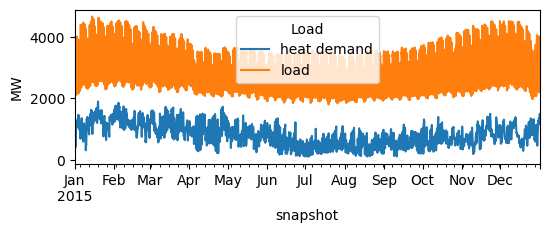

In [37]:
# load electricity demand data
df_heat = pd.read_csv('data/heat_demand.csv', sep=';', index_col=0) # in MWh
df_heat.index = pd.to_datetime(df_heat.index) #change index to datatime
country='IRL'
print(df_heat[country].head())


network.add("Bus",
    "heat bus",
    carrier="heat",
    overwrite=True)

# add load to the bus
network.add("Load",
    "heat demand",
    bus="heat bus",
    p_set=df_heat[country].values*0.2,
    overwrite=True)
network.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

network.add("Link", 
    "heat pump",
    carrier="heat pump",
    bus0="electricity bus",
    bus1="heat bus",
    p_nom_extendable=True,
    capital_cost=costs.at["central air-sourced heat pump", "capital_cost"]*0.1,  # €/MWe/a
    efficiency = 3, #change with COP values
    overwrite=True)



objective_with_heatpump, capacities, loadConsumption, generation, snapshot, status = optimizer("2015")




In [38]:
network.links_t.p0['heat pump']

snapshot
2015-01-01 00:00:00    291.714263
2015-01-01 01:00:00    283.017727
2015-01-01 02:00:00    283.508133
2015-01-01 03:00:00    280.539270
2015-01-01 04:00:00    272.657186
                          ...    
2015-12-31 19:00:00    489.308338
2015-12-31 20:00:00    496.284785
2015-12-31 21:00:00    499.177630
2015-12-31 22:00:00    498.018144
2015-12-31 23:00:00    495.115772
Name: heat pump, Length: 8760, dtype: float64

In [39]:
network.add("Bus", "gas bus")

# We add a gas store with energy capacity and an initial filling level much higher than the required gas consumption, 
# this way gas supply is unlimited
network.add("Store", "gas storage", e_initial=1e6, e_nom=1e6, bus="gas bus") 

network.add(
    "Link",
    "CHP",
    bus0="gas bus",
    bus1="electricity bus",
    bus2="heat bus",
    p_nom=1000,
    marginal_cost=80, #gas price maybe
    efficiency=0.4,
    efficiency2=0.4,
    capital_cost=costs.at["decentral CHP", "capital_cost"],  # €/MWe/a

)

Index(['CHP'], dtype='object')

In [40]:
objective_with_heatpump_and_CHP, capacities, loadConsumption, generation, snapshot, status = optimizer("2015")


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['Hydro pump', 'Ireland - Britain', 'Ireland - France', 'heat pump',
       'CHP'],
      dtype='object', name='Link')
Index(['gas storage'], dtype='object', name='Store')
Index(['electricity bus Britain', 'electricity bus France', 'heat bus',
       'gas bus', 'electricity bus'],
      dtype='object', name='Bus')
Index(['Hydro pump', 'Ireland - Britain', 'Ireland - France', 'heat pump',
       'CHP'],
      dtype='object', name='Link')
Index(['gas storage'], dtype='object', name='Store')
Index(['electricity bus Britain', 'electricity bus France', 'heat bus',
       'gas bus', 'electricity bus'],
      dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 48.86it/s]
INFO:linopy.io: Writing time: 0.99s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-5thna_3b.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-5thna_3b.lp


Reading time = 0.32 seconds


INFO:gurobipy:Reading time = 0.32 seconds


obj: 367948 rows, 166455 columns, 731486 nonzeros


INFO:gurobipy:obj: 367948 rows, 166455 columns, 731486 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 166455 primals, 367948 duals
Objective: 9.34e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


* Missing the COP for heat pump
* Missing extension to the country links maybe
* How do we know if the CHP is producing heat or electricity
* What should the marginal price of CHP be?
* Check at capital cost for CHP er korrekt (på nette evt.)

<Axes: title={'center': 'Electricity'}>

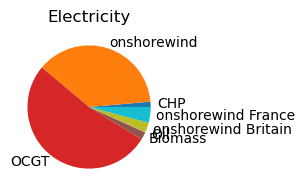

In [41]:
pd.concat([-network.links_t.p1['CHP'], network.generators_t.p], axis=1).sum().plot.pie(figsize=(6, 2), title='Electricity')


<Axes: title={'center': 'Heat'}>

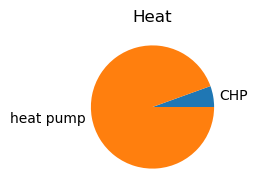

In [42]:
pd.concat([-network.links_t.p2['CHP'],-network.links_t.p1['heat pump']], axis=1).sum().plot.pie(figsize=(6, 2), title='Heat')
